<a href="https://colab.research.google.com/github/vintagedeek/CICIDS2017/blob/master/cicids2017_2020_07_23_97_val_acc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [112]:
import pandas as pd
import numpy as np
from sklearn import preprocessing

from collections import OrderedDict, namedtuple
from itertools import product
import time
from IPython.display import display, clear_output
import json

import torch 
from torchvision.transforms import Normalize
import torch.nn as nn 
import torch.optim as optim
import torch.nn.functional as F

from scipy.ndimage.interpolation import shift
from PIL import Image

import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('seaborn-whitegrid')

In [113]:
train_url = 'https://raw.githubusercontent.com/r-dube/CICIDS2017/master/MachineLearningCVE/processed/bal-cicids2017.csv'
df_train = pd.read_csv(train_url)

In [114]:
df_train.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64,X65,X66,X67,X68,X69,X70,X71,X72,X73,X74,X75,X76,X77,X78,YY
0,53,31065,2,2,68,132,34,34,34.0,0.0,66,66,66.0,0.0,1.035500e+04,1.789123e+04,31014,3,3,3.0,0.000000,3,3,48,48.0,0.000000,48,48,0,0,0,0,64,64,64.381136,64.381136,34,66,46.800000,17.527122,307.200000,0,0,0,0,0,0,0,0,1,58.5,34.0,66.0,64,0,0,0,0,0,0,2,68,2,132,-1,-1,1,32,0.0,0.000000,0,0,0.0,0.000000,0,0,0
1,123,67042799,2,2,96,96,48,48,48.0,0.0,48,48,48.0,0.0,2.230000e+07,3.860000e+07,67000000,43166,67000000,67000000.0,0.000000,67000000,67000000,67000000,67000000.0,0.000000,67000000,67000000,0,0,0,0,64,64,0.029832,0.029832,48,48,48.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,1,60.0,48.0,48.0,64,0,0,0,0,0,0,2,96,2,96,-1,-1,1,32,43166.0,0.000000,43166,43166,67000000.0,0.000000,67000000,67000000,0
2,53,49637,2,2,180,294,90,90,90.0,0.0,147,147,147.0,0.0,1.654567e+04,2.861464e+04,49587,3,3,3.0,0.000000,3,3,47,47.0,0.000000,47,47,0,0,0,0,64,40,40.292524,40.292524,90,147,112.800000,31.220186,974.700000,0,0,0,0,0,0,0,0,1,141.0,90.0,147.0,64,0,0,0,0,0,0,2,180,2,294,-1,-1,1,32,0.0,0.000000,0,0,0.0,0.000000,0,0,0
3,53,48242,1,1,44,92,44,44,44.0,0.0,92,92,92.0,0.0,4.824200e+04,0.000000e+00,48242,48242,0,0.0,0.000000,0,0,0,0.0,0.000000,0,0,0,0,0,0,20,20,20.728825,20.728825,44,92,60.000000,27.712813,768.000000,0,0,0,0,0,0,0,0,1,90.0,44.0,92.0,20,0,0,0,0,0,0,1,44,1,92,-1,-1,0,20,0.0,0.000000,0,0,0.0,0.000000,0,0,0
4,443,90102413,3,3,18,0,6,6,6.0,0.0,0,0,0.0,0.0,1.802048e+07,2.462721e+07,45000562,34973,90067231,45033615.5,2714.582933,45035535,45031696,90067440,45033720.0,3715.139028,45036347,45031093,0,0,0,0,60,96,0.033295,0.033295,0,6,3.428571,3.207135,10.285714,0,0,0,0,1,0,0,0,1,4.0,6.0,0.0,60,0,0,0,0,0,0,3,18,3,0,251,66,2,20,35379.0,574.170706,35785,34973,44998236.5,3288.753639,45000562,44995911,0


In [115]:
df_train['YY'].value_counts()

0     40000
12     8000
11     8000
10     8000
9      8000
8      8000
7      8000
6      8000
5      8000
4      8000
3      8000
2      8000
1      8000
Name: YY, dtype: int64

In [116]:
df_train.iloc[0:40001]['YY'].value_counts()

0    40000
1        1
Name: YY, dtype: int64

In [117]:
df_train = df_train.iloc[32000:]
df_train = df_train.sample(frac=1).reset_index(drop=True) # Here, specifying drop=True prevents .reset_index from creating a column containing the old index entries.
df_train['YY'].value_counts()
# https://stackoverflow.com/questions/29576430/shuffle-dataframe-rows

12    8000
11    8000
10    8000
9     8000
8     8000
7     8000
6     8000
5     8000
4     8000
3     8000
2     8000
1     8000
0     8000
Name: YY, dtype: int64

In [118]:
df_train.iloc[:, -1]

0          2
1          2
2          6
3         10
4          6
          ..
103995    10
103996    10
103997    12
103998     7
103999     7
Name: YY, Length: 104000, dtype: int64

# Standardization using sklearn
- See below. StandardScaler() standardizes each feature (each column of array).


- Since we fit on the training data only, the mean and standard deviation will only be based on the training data. Not the validation or test data.


- The validation data is standardized using mean/std that came from only the training data (so the validation data hasn't leaked into the training data).This prevents overfitting.


- It also makes sense. Our weights are trained based on a random variable X - mean / std. If we use different mean/std for validation data, we have created a new random variable and our weights do not apply to that random variable.

In [119]:
df_train_copy = df_train[0:83200].copy()
y = df_train_copy['YY']
scaler = preprocessing.StandardScaler()
z = df_train_copy.iloc[:, :-1].values.copy()
train = torch.tensor(scaler.fit_transform(z), dtype=torch.float32)
train_labels = torch.tensor(df_train_copy['YY'].values.copy(), dtype=torch.int64).squeeze()

df_train_copy2 = df_train[83200:].copy()
vy = df_train_copy2['YY']
v = df_train_copy2.iloc[:, :-1].values.copy()
val = torch.tensor(scaler.transform(v), dtype=torch.float32)
val_labels = torch.tensor(df_train_copy2.iloc[:, -1].values.copy()).squeeze()

print(train.shape, train_labels.shape, val.shape, val_labels.shape)

torch.Size([83200, 76]) torch.Size([83200]) torch.Size([20800, 76]) torch.Size([20800])


In [120]:
val_labels

tensor([ 7,  5,  8,  ..., 12,  7,  7])

In [121]:
train_labels[80000:80002]

tensor([ 8, 10])

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [130]:
class RunBuilder():
    @staticmethod
    def get_runs(params):

        Run = namedtuple('Run', params.keys())

        runs = []
        for v in product(*params.values()):
            runs.append(Run(*v))

        return runs

class RunManager():
    def __init__(self):
        self.epoch_count = 0
        self.epoch_loss = 0
        self.epoch_num_correct = 0
        self.val_correct = 0
        self.epoch_start_time = None
        
        self.run_params = None
        self.run_count = 0
        self.run_data = []
        self.run_start_time = None
        
        self.network = None

       
    def begin_run(self, run, network):
        self.run_start_time = time.time()
        
        self.epoch_count = 0
        self.run_params = run
        self.run_count += 1
        
        self.network = network
        
    def end_run(self):
        self.epoch_count = 0
    
    def begin_epoch(self):
        self.epoch_start_time = time.time()
        self.epoch_count += 1
        self.epoch_loss = 0
        self.epoch_num_correct = 0
        self.val_correct = 0
    
    def end_epoch(self):
        epoch_duration = time.time() - self.epoch_start_time
        run_duration = time.time() - self.run_start_time
        
        loss = self.epoch_loss / len(train)
        train_accuracy = self.epoch_num_correct / len(train)

        val_accuracy = self.val_correct/len(validation_set)

            
        results = OrderedDict()
        results["run"] = self.run_count
        results['epoch'] = self.epoch_count
        results['loss'] = loss
        results['train_accuracy'] = train_accuracy
        results['val_accuracy'] = val_accuracy
        results['epoch duration'] = epoch_duration
        results['run duration'] = run_duration
        for k, v in self.run_params._asdict().items(): results[k] = v
        self.run_data.append(results)
        df = pd.DataFrame.from_dict(self.run_data, orient='columns')
        clear_output(wait=True)
        display(df)
    
    def track_loss(self, loss):
        self.epoch_loss += loss.item() * 10
    
    def track_num_correct(self, preds, labels):
        self.epoch_num_correct += self._get_num_correct(preds, labels)
      
    def track_val_accuracy(self, model):
        with torch.no_grad():
            validation_preds = model(validation_set)
            self.val_correct += validation_preds.argmax(dim=1).eq(validation_labels).sum().item()
   
    @torch.no_grad()
    def _get_num_correct(self, preds, labels):
        return preds.argmax(dim=1).eq(labels).sum().item()
    
    def save(self, fileName): # save in json and csv
        
        pd.DataFrame.from_dict(self.run_data, orient='columns').to_csv(f'{fileName}.csv')
        
        with open(f'{fileName}.json', 'w', encoding='utf-8') as f:
            json.dump(self.run_data, f, ensure_ascii=False, indent=4)

In [132]:
validation_set = val.to(device)
validation_labels = val_labels.to(device)

params = OrderedDict(
    lr = [0.004],
    batch_size = [8],
    device = ['cuda'],
    weight_decay = [0.0])#, 1.0, 10.0])

m = RunManager()
for run in RunBuilder.get_runs(params):

    network = nn.Sequential(
        nn.Linear(in_features=76, out_features=26),
        nn.Sigmoid(),
        nn.BatchNorm1d(26),
        nn.Linear(in_features=26, out_features=13),
        nn.Sigmoid()).to(device)
    
    mini_batches = [train[k:k + run.batch_size] for k in range(0, train_labels.shape[0], run.batch_size)]
    mini_labels = [train_labels[k:k + run.batch_size] for k in range(0, train_labels.shape[0], run.batch_size)]
    optimizer = optim.Adam(network.parameters(), lr=run.lr, weight_decay=run.weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    m.begin_run(run, network)
    for epoch in range(35):
        m.begin_epoch()
        for b in range(0, len(mini_batches)):
            images = mini_batches[b].to(device)
            labels = mini_labels[b].to(device)
            preds = network(images) # pass batch
            loss = F.cross_entropy(preds, labels) # calculate loss
            optimizer.zero_grad() # zero gradients
            loss.backward() # calculate gradients
            optimizer.step() # update weights

            m.track_loss(loss)
            m.track_num_correct(preds, labels)
        m.track_val_accuracy(network)
        m.end_epoch()
        scheduler.step()
    m.end_run()

pd.DataFrame.from_dict(m.run_data).sort_values('val_accuracy', ascending=False)[0:15]

,run,epoch,loss,train_accuracy,val_accuracy,epoch duration,run duration,lr,batch_size,device,weight_decay
0,1,1,2.231982,0.876298,0.932500,12.517837,12.517846,0.004,8,cuda,0.0
1,1,2,2.177456,0.931839,0.951202,12.463891,25.010571,0.004,8,cuda,0.0
2,1,3,2.168921,0.943305,0.958990,12.720226,37.758714,0.004,8,cuda,0.0
3,1,4,2.163979,0.952332,0.961923,12.582878,50.369850,0.004,8,cuda,0.0
4,1,5,2.160005,0.957067,0.964471,12.736349,63.135791,0.004,8,cuda,0.0
5,1,6,2.157491,0.959651,0.965529,12.677751,75.841687,0.004,8,cuda,0.0
6,1,7,2.156463,0.960084,0.965721,12.860729,88.735614,0.004,8,cuda,0.0
7,1,8,2.155709,0.961743,0.967404,12.503357,101.268538,0.004,8,cuda,0.0
8,1,9,2.155527,0.962668,0.967308,12.597243,113.893369,0.004,8,cuda,0.0
9,1,10,2.154760,0.962584,0.966346,12.439781,126.362234,0.004,8,cuda,0.0


,run,epoch,loss,train_accuracy,val_accuracy,epoch duration,run duration,lr,batch_size,device,weight_decay
18,1,19,2.144858,0.968474,0.971394,12.531429,243.412296,0.004,8,cuda,0.0
17,1,18,2.145009,0.968377,0.971346,12.606665,230.847864,0.004,8,cuda,0.0
20,1,21,2.144276,0.968714,0.971346,12.599318,268.754731,0.004,8,cuda,0.0
21,1,22,2.144091,0.968822,0.971298,12.667478,281.456055,0.004,8,cuda,0.0
22,1,23,2.144020,0.968810,0.971298,12.742537,294.233719,0.004,8,cuda,0.0
23,1,24,2.143979,0.968858,0.971298,12.701012,306.967434,0.004,8,cuda,0.0
19,1,20,2.144693,0.968594,0.971298,12.678322,256.124142,0.004,8,cuda,0.0
15,1,16,2.145406,0.968341,0.971250,12.530978,205.362313,0.004,8,cuda,0.0
16,1,17,2.145179,0.968293,0.971250,12.814775,218.209979,0.004,8,cuda,0.0
27,1,28,2.143882,0.968870,0.971202,12.656308,357.769955,0.004,8,cuda,0.0


In [139]:
m.save('cicids_batch_lr_grid_search_validation')

# Best Run Data
- hit 97.0288% on epoch 29
- scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
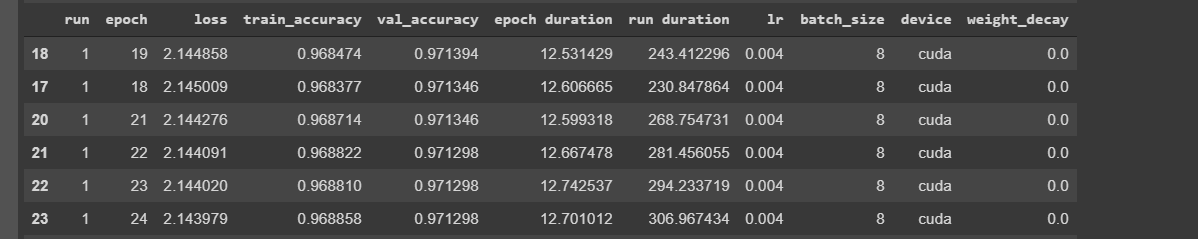

In [97]:
m.val_correct

0

In [98]:
x=network(validation_set)

In [100]:
val_corr = 0
val_corr += x.argmax(dim=1).eq(validation_labels).sum().item()

In [108]:
x.argmax(dim=1)[999:1043]

tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0,
        0, 0, 0, 1, 0, 1, 0, 0, 0, 4, 3, 0, 0, 0, 0, 0, 0, 0, 2, 0],
       device='cuda:0')

In [110]:
validation_labels

tensor([10, 10, 10,  ..., 12, 12, 12], device='cuda:0')